In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Requirements

In [2]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
import tqdm as tqdm
import cv2
import cv2 as cv
import time
from tensorflow.keras.utils import Sequence
from moviepy.editor import VideoFileClip, ImageSequenceClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1335296/45929032 bytes (2.9%)3178496/45929032 bytes (6.9%)5922816/45929032 bytes (12.9%)8478720/45929032 bytes (18.5%)10936320/45929032 bytes (23.8%)13279232/45929032 bytes (28.9%)15753216/45929032 bytes (34.3%)19357696/45929032 bytes (42.1%)22953984/45929032 bytes (50.0%)26460160/45929032 bytes (57.6%)30081024/45929032 bytes (65.5%)33701888/45929032 bytes (73.4%)370

# Losses

In [14]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

# Define U-Net model

In [ ]:
def unet(num_classes, input_shape, lr_init, vgg_weight_path=None):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(img_input, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # last conv
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=lr_init),
                  loss= [total_loss,'categorical_crossentropy'], metrics=[dice_coeff, 'accuracy'])
    return model

# Data

In [ ]:
img_height, img_width = 256, 512
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [4]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

In [5]:
from keras.preprocessing.image import ImageDataGenerator
def pre_processing(img):
    # Random exposure and saturation (0.9 ~ 1.1 scale)
    rand_s = random.uniform(0.9, 1.1)
    rand_v = random.uniform(0.9, 1.1)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    tmp = np.ones_like(img[:, :, 1]) * 255
    img[:, :, 1] = np.where(img[:, :, 1] * rand_s > 255, tmp, img[:, :, 1] * rand_s)
    img[:, :, 2] = np.where(img[:, :, 2] * rand_v > 255, tmp, img[:, :, 2] * rand_v)

    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    # Centering helps normalization image (-1 ~ 1 value)
    return img / 127.5 - 1

def get_data_gen_args(mode):
    if mode == 'train' or mode == 'val':
        x_data_gen_args = dict(preprocessing_function=pre_processing,
                               shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

        y_data_gen_args = dict(shear_range=0.1,
                               zoom_range=0.1,
                               rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               fill_mode='constant',
                               horizontal_flip=True)

    elif mode == 'test':
        x_data_gen_args = dict(preprocessing_function=pre_processing)
        y_data_gen_args = dict()

    else:
        print("Data_generator function should get mode arg 'train' or 'val' or 'test'.")
        return -1

    return x_data_gen_args, y_data_gen_args

# One hot encoding for y_img.
def get_result_map(b_size, y_img):
    y_img = np.squeeze(y_img, axis=3)
    result_map = np.zeros((b_size, 256, 512, 4))

    # For np.where calculation.
    person = (y_img == 24)
    person1 = (y_img == 25)
    person = np.logical_or(person, person1)

    car = (y_img == 26)
    car1 = (y_img == 27)
    car2 = (y_img == 28)
    car3 = (y_img == 29)
    car4 = (y_img == 30)
    car5 = (y_img == 31)
    car6 = (y_img == 32)
    car7 = (y_img == 33)
    car8 = (y_img == -1)
    
    car = np.logical_or(car , car1)
    car = np.logical_or(car , car2)
    car = np.logical_or(car , car3)
    car = np.logical_or(car , car4)
    car = np.logical_or(car , car5)
    car = np.logical_or(car , car6)
    car = np.logical_or(car , car7)
    car = np.logical_or(car , car8)

    road = (y_img == 7)

    background = np.logical_not(person + car + road)

    result_map[:, :, :, 0] = np.where(background, 1, 0)
    result_map[:, :, :, 1] = np.where(person, 1, 0)
    result_map[:, :, :, 2] = np.where(car, 1, 0)
    result_map[:, :, :, 3] = np.where(road, 1, 0)

    return result_map

# Data generator for fit_generator.
def data_generator(dataset, b_size, mode):

    x_imgs = dataset[0]
    y_imgs = dataset[1]

    # Make ImageDataGenerator.
    x_data_gen_args, y_data_gen_args = get_data_gen_args(mode)
    x_data_gen = ImageDataGenerator(**x_data_gen_args)
    y_data_gen = ImageDataGenerator(**y_data_gen_args)

    # random index for random data access.
    d_size = x_imgs.shape[0]
    shuffled_idx = list(range(d_size))

    x = []
    y = []
    while True:
        random.shuffle(shuffled_idx)
        for i in range(d_size):
            idx = shuffled_idx[i]

            x.append(x_imgs[idx].reshape((256, 512, 3)))
            y.append(y_imgs[idx].reshape((256, 512, 1)))

            if len(x) == b_size:
                # Adapt ImageDataGenerator flow method for data augmentation.
                _ = np.zeros(b_size)
                seed = random.randrange(1, 1000)

                x_tmp_gen = x_data_gen.flow(np.array(x), _,
                                            batch_size=b_size,
                                            seed=seed)
                y_tmp_gen = y_data_gen.flow(np.array(y), _,
                                            batch_size=b_size,
                                            seed=seed)

                # Finally, yield x, y data.
                x_result, _ = next(x_tmp_gen)
                y_result, _ = next(y_tmp_gen)

                yield x_result, get_result_map(b_size, y_result)

                x.clear()
                y.clear()

def load_data(lst_path_x, lst_path_y):
    images = []
    labels = []
    # i = 0
    # l = len(lst_path_x)
    for x,y in tqdm.tqdm(zip(lst_path_x, lst_path_y)):
        images.append(cv2.cvtColor(cv.resize(cv.imread(x),(512,256)), cv2.COLOR_BGR2RGB))

        y_img = cv.resize(cv.imread(y),(512,256))
        y_img = y_img[:, :, 0]
        labels.append(y_img)
        
    return np.asarray(images),np.asarray(labels)

# Train

In [ ]:
!nvidia-smi

Tue Dec 28 03:07:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    59W / 149W |    655MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dataset Kitti 

In [6]:
image_path = "/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/training/image_2/"
mask_path = "/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/training/semantic/"
  
lst_train_x = sorted([image_path + f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))])
lst_train_y = sorted([mask_path + f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

print(len(lst_train_x),len(lst_train_y))

200 200


In [7]:
dataset = load_data(lst_train_x, lst_train_y)

200it [01:00,  3.29it/s]


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset[0], dataset[1], test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Visual example of dataset

<Figure size 720x720 with 0 Axes>

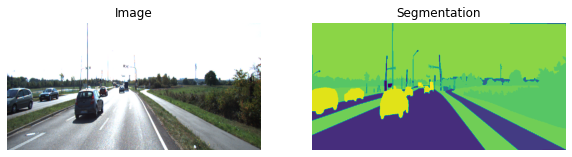

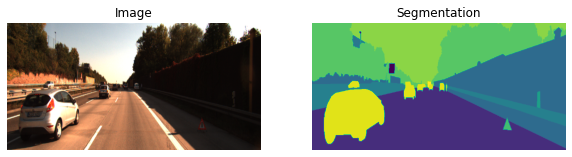

In [9]:
import matplotlib.pyplot as plt

idx = 0
plt.figure(figsize=(10, 10))
for images, lables in zip(X_train,  y_train):
    fig, arr = plt.subplots(1, 2 , figsize=(10, 10))
    arr[0].imshow(images)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(lables)
    arr[1].set_title('Segmentation')
    arr[1].axis("off") 
    idx +=1
    if idx ==2:
      break

## Load pretrained model VGG16 offered by keras.

In [ ]:
!gdown --id 152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1

Downloading...
From: https://drive.google.com/uc?id=152DjgAX7OzUYl1vnd94ofwOOxjpTg6-1
To: /content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
100% 58.9M/58.9M [00:00<00:00, 185MB/s] 


## Initialize parameter and callback

In [17]:
batch_size = 10 # Batch size for train.
val_batch = 10 # Batch size for validation.
lr_init = 1e-4 # Initial learning rate.
# lr_decay = 5e-4 # How much to decay the learning rate.
vgg_path = "/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # Pretrained vgg16 weight path.

# val_dice_coeff
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
model_checkpoint = ModelCheckpoint('kitti-unet-semantic-model.h5', monitor='acc',verbose=1, save_best_only=True)

In [18]:
# Use only 3 classes.
labels = ['background', 'person', 'car', 'road']

## Initialize model Unet with VGG 16 pretrained

In [ ]:
tf.keras.backend.clear_session()
model = unet(input_shape=(256, 512, 3), 
             num_classes=len(labels),
             lr_init=lr_init, 
             vgg_weight_path=vgg_path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 512, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                           

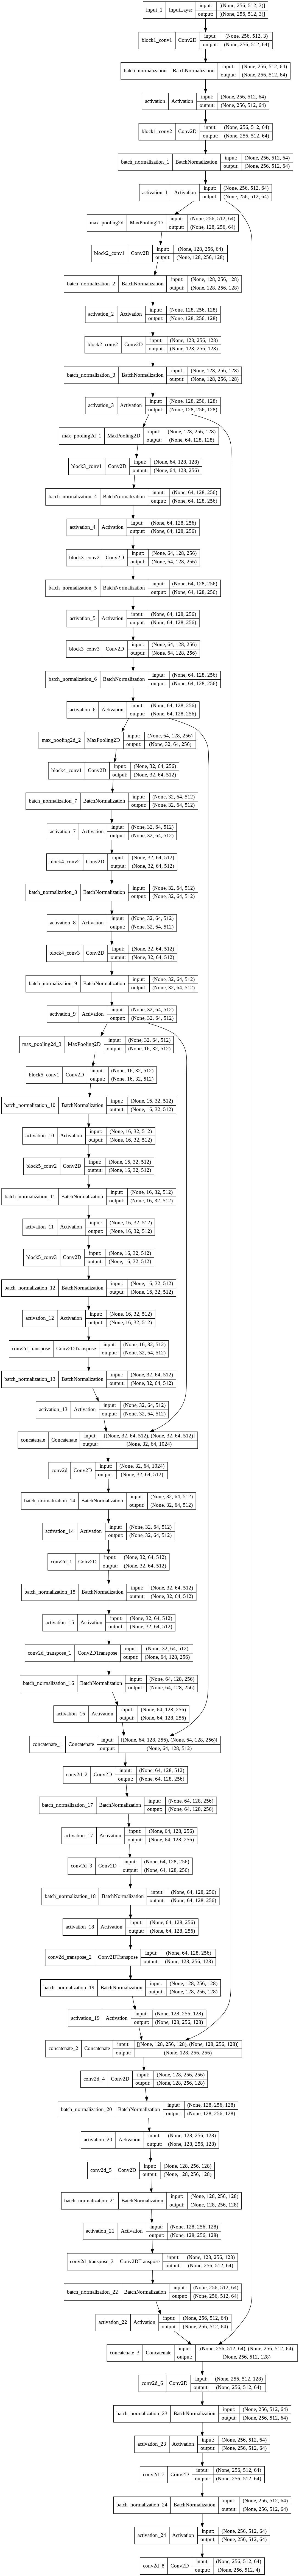

In [ ]:
tf.keras.utils.plot_model(model, show_shapes= True)

## Model training

In [ ]:
history = model.fit_generator(data_generator([X_train, y_train], batch_size, 'train'),
                              steps_per_epoch=160 // batch_size,
                              validation_data=data_generator([X_val, y_val], val_batch, 'val'),
                              validation_steps=20 // val_batch,
                              callbacks=[callback, reduce_lr,model_checkpoint],
                              epochs=100,
                              verbose=1)

Epoch 1/100
16/16 [==============================] - 81s 4s/step - loss: 2.4177 - dice_coeff: 0.3929 - accuracy: 0.5356 - val_loss: 3.2143 - val_dice_coeff: 0.1903 - val_accuracy: 0.0911 - lr: 1.0000e-04
Epoch 2/100
16/16 [==============================] - 62s 4s/step - loss: 1.3273 - dice_coeff: 0.6871 - accuracy: 0.8412 - val_loss: 2.2467 - val_dice_coeff: 0.4482 - val_accuracy: 0.5662 - lr: 1.0000e-04
Epoch 3/100
16/16 [==============================] - 62s 4s/step - loss: 0.7788 - dice_coeff: 0.8340 - accuracy: 0.9271 - val_loss: 2.2408 - val_dice_coeff: 0.4363 - val_accuracy: 0.5188 - lr: 1.0000e-04
Epoch 4/100
16/16 [==============================] - 61s 4s/step - loss: 0.5607 - dice_coeff: 0.8874 - accuracy: 0.9353 - val_loss: 2.2249 - val_dice_coeff: 0.4407 - val_accuracy: 0.5111 - lr: 1.0000e-04
Epoch 5/100
16/16 [==============================] - 62s 4s/step - loss: 0.4842 - dice_coeff: 0.9050 - accuracy: 0.9372 - val_loss: 1.7005 - val_dice_coeff: 0.5759 - val_accuracy: 0.76

In [ ]:
model.save('/content/drive/MyDrive/Đồ án khmt/CS406/kitti-unet-semantic-model.h5')

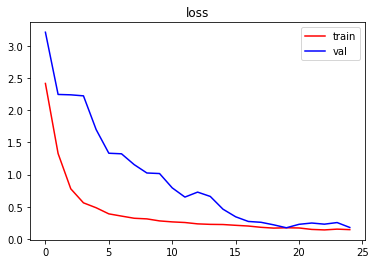

In [ ]:
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_loss.png')

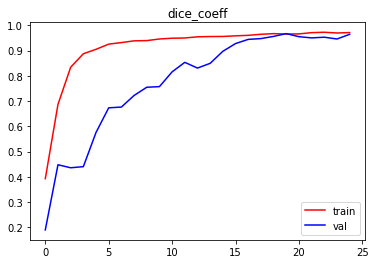

In [ ]:
plt.gcf().clear()
plt.title("dice_coeff")
plt.plot(history.history["dice_coeff"], color="r", label="train")
plt.plot(history.history["val_dice_coeff"], color="b", label="val")
plt.legend(loc="best")
plt.savefig('Unet_dice_coeff.png')

In [19]:
model_loaded.evaluate(data_generator([X_test, y_test], 10, 'test'),steps = 10, callbacks=[callback, reduce_lr,model_checkpoint])

10/10 [==============================] - 9s 894ms/step - loss: 0.3106 - dice_coeff: 0.9359 - accuracy: 0.9443


[0.3105781674385071, 0.9358575940132141, 0.9442839622497559]

# Testing

In [15]:
model_loaded = load_model('/content/drive/MyDrive/Đồ án khmt/CS406/kitti-unet-semantic-model.h5', custom_objects= {'dice_coeff':dice_coeff, 'total_loss':total_loss})

## By image

downloading https://thumbs.dreamstime.com/z/car-drives-fast-highway-highlands-black-148886931.jpg


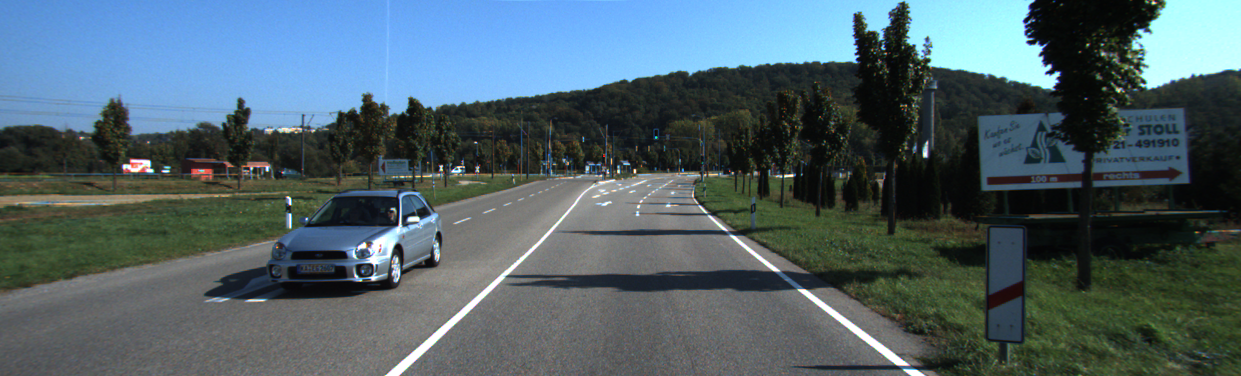

total time taken = 0.32686877250671387 s


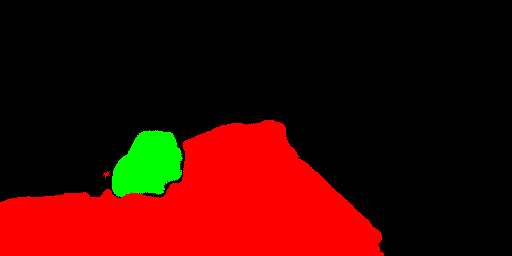

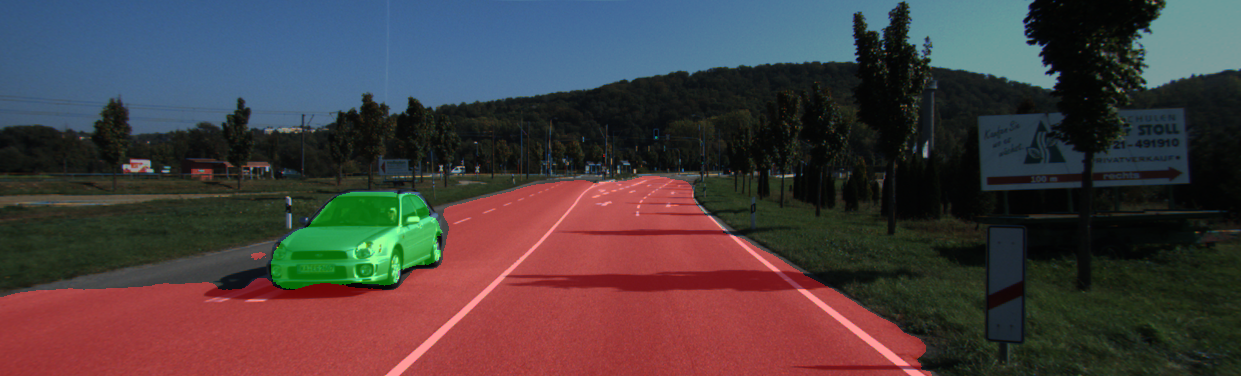

'   0 : Background : None\n      1 : road : Red\n      2 : vehicle : Green\n      3 : human : Blue\n'

In [ ]:
from google.colab.patches import cv2_imshow
from skimage import io
import time

def result_map_to_img(res_map):
    img = np.zeros((256, 512, 3), dtype=np.uint8)
    res_map = np.squeeze(res_map)

    argmax_idx = np.argmax(res_map, axis=2)

    # For np.where calculation.
    person = (argmax_idx == 1)
    car = (argmax_idx == 2)
    road = (argmax_idx == 3)

    img[:, :, 0] = np.where(person, 255, 0)
    img[:, :, 1] = np.where(car, 255, 0)
    img[:, :, 2] = np.where(road, 255, 0)

    return img

color_map = {
 '0': [0, 0, 0],
 '1': [255, 0, 0],
 '2': [0, 255, 0],
 '3': [0, 0, 255]
}

def pp(image,mask):
    alpha = 0.6
    dims = image.shape
    z = cv2.resize(mask, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)

    img_color = image.copy()
    for i in range(dims[0]):
        for j in range(dims[1]):
            img_color[i, j] = color_map[str(y[i, j])]
    cv2.addWeighted(image, alpha, img_color, 1-alpha, 0, img_color)
    return img_color
def show_img_demo(x_img_org, show = True):
  if show:
    cv2_imshow(x_img_org)
  x_img = cv2.cvtColor(cv.resize(x_img_org, (512,256)), cv2.COLOR_BGR2RGB)
  x_img = x_img / 127.5 - 1
  x_img = np.expand_dims(x_img, 0)

  s = time.time()
  pred = model_loaded.predict(x_img)
  e = time.time()
  t = e-s
  print(f'total time taken = {t} s')
  res = result_map_to_img(pred[0])
  if show:
    cv2_imshow(res)
  img_w_mask = pp(x_img_org, pred[0])
  if show:
    cv2_imshow(img_w_mask)
  return img_w_mask, t
url = "https://thumbs.dreamstime.com/z/car-drives-fast-highway-highlands-black-148886931.jpg"
print(f"downloading {url}")
img_sample = io.imread(url)

x_img_org = cv2.imread("/content/drive/MyDrive/Đồ án khmt/CS406/data_semantics/testing/image_2/000190_10.png")
show_img_demo(x_img_org)
'''   0 : Background : None
      1 : road : Red
      2 : vehicle : Green
      3 : human : Blue
'''

## By video ( at most 20s)

In [ ]:
import cv2
import time 
import tqdm
vidcap = cv2.VideoCapture("/content/drive/MyDrive/Đồ án khmt/CS406/stuttgart_01.mp4")
success,image = vidcap.read()
count = 0
times = 0
img2video = []
seconds = 15
fps = int(vidcap.get(cv2.CAP_PROP_FPS)) # Gets the frames per second
print("FPS: ",fps)
multiplier = fps * seconds

for i in tqdm.tqdm(range(multiplier)):   
  success,image = vidcap.read()
  result,t = show_img_demo(image,show = False)
  times += t
  img2video.append(result)
  count += 1

FPS:  30


  0%|          | 0/450 [00:00<?, ?it/s]

total time taken = 0.35170698165893555 s


  0%|          | 1/450 [00:00<04:59,  1.50it/s]

total time taken = 0.2979857921600342 s


  0%|          | 2/450 [00:01<04:44,  1.58it/s]

total time taken = 0.3045639991760254 s


  1%|          | 3/450 [00:01<04:41,  1.59it/s]

total time taken = 0.3063485622406006 s


  1%|          | 4/450 [00:02<04:41,  1.58it/s]

total time taken = 0.2996561527252197 s


  1%|          | 5/450 [00:03<04:38,  1.60it/s]

total time taken = 0.3505394458770752 s


  1%|▏         | 6/450 [00:04<05:49,  1.27it/s]

total time taken = 0.3688318729400635 s


  2%|▏         | 7/450 [00:05<06:37,  1.11it/s]

total time taken = 0.40004777908325195 s


  2%|▏         | 8/450 [00:06<07:12,  1.02it/s]

total time taken = 0.40255045890808105 s


  2%|▏         | 9/450 [00:07<07:32,  1.03s/it]

total time taken = 0.38475942611694336 s


  2%|▏         | 10/450 [00:08<07:32,  1.03s/it]

total time taken = 0.3814253807067871 s


  2%|▏         | 11/450 [00:09<07:38,  1.04s/it]

total time taken = 0.39200878143310547 s


  3%|▎         | 12/450 [00:10<07:35,  1.04s/it]

total time taken = 0.32926321029663086 s


  3%|▎         | 13/450 [00:11<07:27,  1.02s/it]

total time taken = 0.37253856658935547 s


  3%|▎         | 14/450 [00:12<07:26,  1.02s/it]

total time taken = 0.38254499435424805 s


  3%|▎         | 15/450 [00:13<07:23,  1.02s/it]

total time taken = 0.39212703704833984 s


  4%|▎         | 16/450 [00:14<07:27,  1.03s/it]

total time taken = 0.3773002624511719 s


  4%|▍         | 17/450 [00:15<06:42,  1.08it/s]

total time taken = 0.2965052127838135 s


  4%|▍         | 18/450 [00:16<05:59,  1.20it/s]

total time taken = 0.2973756790161133 s


  4%|▍         | 19/450 [00:16<05:30,  1.30it/s]

total time taken = 0.3027818202972412 s


  4%|▍         | 20/450 [00:17<05:11,  1.38it/s]

total time taken = 0.29816460609436035 s


  5%|▍         | 21/450 [00:18<04:58,  1.44it/s]

total time taken = 0.30217623710632324 s


  5%|▍         | 22/450 [00:18<04:48,  1.48it/s]

total time taken = 0.2953784465789795 s


  5%|▌         | 23/450 [00:19<04:39,  1.53it/s]

total time taken = 0.29935288429260254 s


  5%|▌         | 24/450 [00:19<04:34,  1.55it/s]

total time taken = 0.2980537414550781 s


  6%|▌         | 25/450 [00:20<04:29,  1.58it/s]

total time taken = 0.29705810546875 s


  6%|▌         | 26/450 [00:21<04:26,  1.59it/s]

total time taken = 0.2953522205352783 s


  6%|▌         | 27/450 [00:21<04:24,  1.60it/s]

total time taken = 0.3045332431793213 s


  6%|▌         | 28/450 [00:22<04:23,  1.60it/s]

total time taken = 0.2950577735900879 s


  6%|▋         | 29/450 [00:22<04:22,  1.60it/s]

total time taken = 0.29953670501708984 s


  7%|▋         | 30/450 [00:23<04:20,  1.61it/s]

total time taken = 0.3496074676513672 s


  7%|▋         | 31/450 [00:24<04:25,  1.58it/s]

total time taken = 0.29741644859313965 s


  7%|▋         | 32/450 [00:24<04:23,  1.59it/s]

total time taken = 0.3078043460845947 s


  7%|▋         | 33/450 [00:25<04:20,  1.60it/s]

total time taken = 0.2961897850036621 s


  8%|▊         | 34/450 [00:26<04:19,  1.61it/s]

total time taken = 0.2962789535522461 s


  8%|▊         | 35/450 [00:26<04:16,  1.62it/s]

total time taken = 0.30558061599731445 s


  8%|▊         | 36/450 [00:27<04:14,  1.63it/s]

total time taken = 0.2986900806427002 s


  8%|▊         | 37/450 [00:27<04:12,  1.64it/s]

total time taken = 0.297344446182251 s


  8%|▊         | 38/450 [00:28<04:12,  1.63it/s]

total time taken = 0.29813313484191895 s


  9%|▊         | 39/450 [00:29<04:12,  1.63it/s]

total time taken = 0.30119895935058594 s


  9%|▉         | 40/450 [00:29<04:10,  1.63it/s]

total time taken = 0.3513321876525879 s


  9%|▉         | 41/450 [00:30<04:16,  1.59it/s]

total time taken = 0.29986143112182617 s


  9%|▉         | 42/450 [00:31<04:13,  1.61it/s]

total time taken = 0.3036649227142334 s


 10%|▉         | 43/450 [00:31<04:11,  1.62it/s]

total time taken = 0.29486894607543945 s


 10%|▉         | 44/450 [00:32<04:12,  1.60it/s]

total time taken = 0.3087756633758545 s


 10%|█         | 45/450 [00:32<04:11,  1.61it/s]

total time taken = 0.35309314727783203 s


 10%|█         | 46/450 [00:33<04:15,  1.58it/s]

total time taken = 0.29930949211120605 s


 10%|█         | 47/450 [00:34<04:13,  1.59it/s]

total time taken = 0.30075764656066895 s


 11%|█         | 48/450 [00:34<04:10,  1.60it/s]

total time taken = 0.2966878414154053 s


 11%|█         | 49/450 [00:35<04:10,  1.60it/s]

total time taken = 0.29996585845947266 s


 11%|█         | 50/450 [00:36<04:06,  1.62it/s]

total time taken = 0.3003504276275635 s


 11%|█▏        | 51/450 [00:36<04:04,  1.63it/s]

total time taken = 0.2954368591308594 s


 12%|█▏        | 52/450 [00:37<04:04,  1.63it/s]

total time taken = 0.30463552474975586 s


 12%|█▏        | 53/450 [00:37<04:03,  1.63it/s]

total time taken = 0.2977302074432373 s


 12%|█▏        | 54/450 [00:38<04:04,  1.62it/s]

total time taken = 0.2980372905731201 s


 12%|█▏        | 55/450 [00:39<04:02,  1.63it/s]

total time taken = 0.2979004383087158 s


 12%|█▏        | 56/450 [00:39<04:00,  1.64it/s]

total time taken = 0.2965528964996338 s


 13%|█▎        | 57/450 [00:40<03:58,  1.65it/s]

total time taken = 0.30448055267333984 s


 13%|█▎        | 58/450 [00:40<03:58,  1.64it/s]

total time taken = 0.30152463912963867 s


 13%|█▎        | 59/450 [00:41<04:00,  1.63it/s]

total time taken = 0.3089125156402588 s


 13%|█▎        | 60/450 [00:42<03:59,  1.63it/s]

total time taken = 0.3622581958770752 s


 14%|█▎        | 61/450 [00:42<04:05,  1.58it/s]

total time taken = 0.3533501625061035 s


 14%|█▍        | 62/450 [00:43<04:10,  1.55it/s]

total time taken = 0.2963683605194092 s


 14%|█▍        | 63/450 [00:44<04:05,  1.57it/s]

total time taken = 0.29767370223999023 s


 14%|█▍        | 64/450 [00:44<04:01,  1.60it/s]

total time taken = 0.355241060256958 s


 14%|█▍        | 65/450 [00:45<04:06,  1.56it/s]

total time taken = 0.35890626907348633 s


 15%|█▍        | 66/450 [00:46<04:09,  1.54it/s]

total time taken = 0.3527371883392334 s


 15%|█▍        | 67/450 [00:46<04:11,  1.52it/s]

total time taken = 0.2938575744628906 s


 15%|█▌        | 68/450 [00:47<04:04,  1.56it/s]

total time taken = 0.303835391998291 s


 15%|█▌        | 69/450 [00:47<04:01,  1.58it/s]

total time taken = 0.29511523246765137 s


 16%|█▌        | 70/450 [00:48<03:58,  1.59it/s]

total time taken = 0.295961856842041 s


 16%|█▌        | 71/450 [00:49<03:56,  1.61it/s]

total time taken = 0.306896448135376 s


 16%|█▌        | 72/450 [00:49<03:55,  1.60it/s]

total time taken = 0.2965540885925293 s


 16%|█▌        | 73/450 [00:50<03:54,  1.61it/s]

total time taken = 0.2963390350341797 s


 16%|█▋        | 74/450 [00:51<03:52,  1.62it/s]

total time taken = 0.2961924076080322 s


 17%|█▋        | 75/450 [00:51<03:52,  1.61it/s]

total time taken = 0.2985715866088867 s


 17%|█▋        | 76/450 [00:52<03:51,  1.62it/s]

total time taken = 0.2956974506378174 s


 17%|█▋        | 77/450 [00:52<03:51,  1.61it/s]

total time taken = 0.30570507049560547 s


 17%|█▋        | 78/450 [00:53<03:50,  1.61it/s]

total time taken = 0.29850172996520996 s


 18%|█▊        | 79/450 [00:54<03:49,  1.61it/s]

total time taken = 0.2967865467071533 s


 18%|█▊        | 80/450 [00:54<03:48,  1.62it/s]

total time taken = 0.29908204078674316 s


 18%|█▊        | 81/450 [00:55<03:47,  1.62it/s]

total time taken = 0.2984895706176758 s


 18%|█▊        | 82/450 [00:55<03:46,  1.63it/s]

total time taken = 0.3000924587249756 s


 18%|█▊        | 83/450 [00:56<03:45,  1.63it/s]

total time taken = 0.3498494625091553 s


 19%|█▊        | 84/450 [00:57<03:50,  1.59it/s]

total time taken = 0.2968137264251709 s


 19%|█▉        | 85/450 [00:57<03:49,  1.59it/s]

total time taken = 0.3070642948150635 s


 19%|█▉        | 86/450 [00:58<03:47,  1.60it/s]

total time taken = 0.3005998134613037 s


 19%|█▉        | 87/450 [00:59<03:45,  1.61it/s]

total time taken = 0.2993028163909912 s


 20%|█▉        | 88/450 [00:59<03:43,  1.62it/s]

total time taken = 0.3101818561553955 s


 20%|█▉        | 89/450 [01:00<03:43,  1.62it/s]

total time taken = 0.2958512306213379 s


 20%|██        | 90/450 [01:00<03:43,  1.61it/s]

total time taken = 0.29793310165405273 s


 20%|██        | 91/450 [01:01<03:40,  1.63it/s]

total time taken = 0.29799962043762207 s


 20%|██        | 92/450 [01:02<03:39,  1.63it/s]

total time taken = 0.3010718822479248 s


 21%|██        | 93/450 [01:02<03:38,  1.63it/s]

total time taken = 0.31320643424987793 s


 21%|██        | 94/450 [01:03<03:39,  1.62it/s]

total time taken = 0.296252965927124 s


 21%|██        | 95/450 [01:04<03:39,  1.62it/s]

total time taken = 0.29880833625793457 s


 21%|██▏       | 96/450 [01:04<03:37,  1.63it/s]

total time taken = 0.3507359027862549 s


 22%|██▏       | 97/450 [01:05<03:43,  1.58it/s]

total time taken = 0.298583984375 s


 22%|██▏       | 98/450 [01:05<03:42,  1.58it/s]

total time taken = 0.3006439208984375 s


 22%|██▏       | 99/450 [01:06<03:39,  1.60it/s]

total time taken = 0.30162668228149414 s


 22%|██▏       | 100/450 [01:07<03:39,  1.59it/s]

total time taken = 0.30089378356933594 s


 22%|██▏       | 101/450 [01:07<03:38,  1.60it/s]

total time taken = 0.30627012252807617 s


 23%|██▎       | 102/450 [01:08<03:39,  1.59it/s]

total time taken = 0.29820799827575684 s


 23%|██▎       | 103/450 [01:09<03:38,  1.59it/s]

total time taken = 0.2983071804046631 s


 23%|██▎       | 104/450 [01:09<03:36,  1.60it/s]

total time taken = 0.3019528388977051 s


 23%|██▎       | 105/450 [01:10<03:35,  1.60it/s]

total time taken = 0.2978487014770508 s


 24%|██▎       | 106/450 [01:10<03:33,  1.61it/s]

total time taken = 0.2977893352508545 s


 24%|██▍       | 107/450 [01:11<03:32,  1.62it/s]

total time taken = 0.29714465141296387 s


 24%|██▍       | 108/450 [01:12<03:31,  1.62it/s]

total time taken = 0.29575514793395996 s


 24%|██▍       | 109/450 [01:12<03:29,  1.63it/s]

total time taken = 0.30576491355895996 s


 24%|██▍       | 110/450 [01:13<03:30,  1.62it/s]

total time taken = 0.29816150665283203 s


 25%|██▍       | 111/450 [01:14<03:29,  1.62it/s]

total time taken = 0.29448890686035156 s


 25%|██▍       | 112/450 [01:14<03:27,  1.63it/s]

total time taken = 0.3486952781677246 s


 25%|██▌       | 113/450 [01:15<03:32,  1.58it/s]

total time taken = 0.29639697074890137 s


 25%|██▌       | 114/450 [01:15<03:30,  1.60it/s]

total time taken = 0.35192131996154785 s


 26%|██▌       | 115/450 [01:16<03:33,  1.57it/s]

total time taken = 0.35141563415527344 s


 26%|██▌       | 116/450 [01:17<03:36,  1.54it/s]

total time taken = 0.2966346740722656 s


 26%|██▌       | 117/450 [01:17<03:31,  1.58it/s]

total time taken = 0.3007793426513672 s


 26%|██▌       | 118/450 [01:18<03:29,  1.58it/s]

total time taken = 0.29618024826049805 s


 26%|██▋       | 119/450 [01:19<03:25,  1.61it/s]

total time taken = 0.2982480525970459 s


 27%|██▋       | 120/450 [01:19<03:23,  1.62it/s]

total time taken = 0.35293030738830566 s


 27%|██▋       | 121/450 [01:20<03:29,  1.57it/s]

total time taken = 0.2961122989654541 s


 27%|██▋       | 122/450 [01:20<03:26,  1.59it/s]

total time taken = 0.2936077117919922 s


 27%|██▋       | 123/450 [01:21<03:23,  1.60it/s]

total time taken = 0.2964963912963867 s


 28%|██▊       | 124/450 [01:22<03:21,  1.62it/s]

total time taken = 0.30057334899902344 s


 28%|██▊       | 125/450 [01:22<03:20,  1.62it/s]

total time taken = 0.3605315685272217 s


 28%|██▊       | 126/450 [01:23<03:26,  1.57it/s]

total time taken = 0.2985846996307373 s


 28%|██▊       | 127/450 [01:24<03:23,  1.59it/s]

total time taken = 0.30141782760620117 s


 28%|██▊       | 128/450 [01:24<03:21,  1.60it/s]

total time taken = 0.2976338863372803 s


 29%|██▊       | 129/450 [01:25<03:19,  1.61it/s]

total time taken = 0.3065800666809082 s


 29%|██▉       | 130/450 [01:25<03:19,  1.61it/s]

total time taken = 0.2987101078033447 s


 29%|██▉       | 131/450 [01:26<03:18,  1.61it/s]

total time taken = 0.30049920082092285 s


 29%|██▉       | 132/450 [01:27<03:17,  1.61it/s]

total time taken = 0.3003871440887451 s


 30%|██▉       | 133/450 [01:27<03:16,  1.62it/s]

total time taken = 0.35918736457824707 s


 30%|██▉       | 134/450 [01:28<03:21,  1.57it/s]

total time taken = 0.2978646755218506 s


 30%|███       | 135/450 [01:29<03:18,  1.59it/s]

total time taken = 0.29822444915771484 s


 30%|███       | 136/450 [01:29<03:17,  1.59it/s]

total time taken = 0.29598379135131836 s


 30%|███       | 137/450 [01:30<03:15,  1.60it/s]

total time taken = 0.29579997062683105 s


 31%|███       | 138/450 [01:30<03:14,  1.60it/s]

total time taken = 0.299666166305542 s


 31%|███       | 139/450 [01:31<03:13,  1.60it/s]

total time taken = 0.2976980209350586 s


 31%|███       | 140/450 [01:32<03:11,  1.62it/s]

total time taken = 0.3004286289215088 s


 31%|███▏      | 141/450 [01:32<03:12,  1.61it/s]

total time taken = 0.3039381504058838 s


 32%|███▏      | 142/450 [01:33<03:11,  1.61it/s]

total time taken = 0.29982423782348633 s


 32%|███▏      | 143/450 [01:34<03:09,  1.62it/s]

total time taken = 0.2961907386779785 s


 32%|███▏      | 144/450 [01:34<03:08,  1.62it/s]

total time taken = 0.29876184463500977 s


 32%|███▏      | 145/450 [01:35<03:07,  1.62it/s]

total time taken = 0.2992894649505615 s


 32%|███▏      | 146/450 [01:35<03:07,  1.62it/s]

total time taken = 0.3498992919921875 s


 33%|███▎      | 147/450 [01:36<03:11,  1.59it/s]

total time taken = 0.3036351203918457 s


 33%|███▎      | 148/450 [01:37<03:09,  1.59it/s]

total time taken = 0.29848718643188477 s


 33%|███▎      | 149/450 [01:37<03:08,  1.60it/s]

total time taken = 0.305314302444458 s


 33%|███▎      | 150/450 [01:38<03:07,  1.60it/s]

total time taken = 0.2971930503845215 s


 34%|███▎      | 151/450 [01:39<03:05,  1.61it/s]

total time taken = 0.2942085266113281 s


 34%|███▍      | 152/450 [01:39<03:03,  1.62it/s]

total time taken = 0.3066062927246094 s


 34%|███▍      | 153/450 [01:40<03:04,  1.61it/s]

total time taken = 0.35022544860839844 s


 34%|███▍      | 154/450 [01:40<03:08,  1.57it/s]

total time taken = 0.29598402976989746 s


 34%|███▍      | 155/450 [01:41<03:06,  1.59it/s]

total time taken = 0.3006153106689453 s


 35%|███▍      | 156/450 [01:42<03:04,  1.59it/s]

total time taken = 0.3018147945404053 s


 35%|███▍      | 157/450 [01:42<03:04,  1.59it/s]

total time taken = 0.3120453357696533 s


 35%|███▌      | 158/450 [01:43<03:03,  1.59it/s]

total time taken = 0.29951977729797363 s


 35%|███▌      | 159/450 [01:44<03:02,  1.60it/s]

total time taken = 0.3007998466491699 s


 36%|███▌      | 160/450 [01:44<03:00,  1.60it/s]

total time taken = 0.29671406745910645 s


 36%|███▌      | 161/450 [01:45<02:59,  1.61it/s]

total time taken = 0.2999262809753418 s


 36%|███▌      | 162/450 [01:45<03:00,  1.60it/s]

total time taken = 0.3004765510559082 s


 36%|███▌      | 163/450 [01:46<02:57,  1.62it/s]

total time taken = 0.3021378517150879 s


 36%|███▋      | 164/450 [01:47<02:57,  1.62it/s]

total time taken = 0.29445815086364746 s


 37%|███▋      | 165/450 [01:47<02:55,  1.63it/s]

total time taken = 0.30407190322875977 s


 37%|███▋      | 166/450 [01:48<02:56,  1.61it/s]

total time taken = 0.2996499538421631 s


 37%|███▋      | 167/450 [01:49<02:56,  1.61it/s]

total time taken = 0.29785799980163574 s


 37%|███▋      | 168/450 [01:49<02:55,  1.61it/s]

total time taken = 0.3025832176208496 s


 38%|███▊      | 169/450 [01:50<02:54,  1.61it/s]

total time taken = 0.2964174747467041 s


 38%|███▊      | 170/450 [01:50<02:52,  1.62it/s]

total time taken = 0.2981235980987549 s


 38%|███▊      | 171/450 [01:51<02:51,  1.62it/s]

total time taken = 0.296069860458374 s


 38%|███▊      | 172/450 [01:52<02:51,  1.62it/s]

total time taken = 0.2994422912597656 s


 38%|███▊      | 173/450 [01:52<02:50,  1.63it/s]

total time taken = 0.3074479103088379 s


 39%|███▊      | 174/450 [01:53<02:49,  1.63it/s]

total time taken = 0.2993793487548828 s


 39%|███▉      | 175/450 [01:53<02:49,  1.63it/s]

total time taken = 0.29955196380615234 s


 39%|███▉      | 176/450 [01:54<02:47,  1.64it/s]

total time taken = 0.35280847549438477 s


 39%|███▉      | 177/450 [01:55<02:53,  1.57it/s]

total time taken = 0.30374693870544434 s


 40%|███▉      | 178/450 [01:55<02:51,  1.59it/s]

total time taken = 0.29816770553588867 s


 40%|███▉      | 179/450 [01:56<02:51,  1.58it/s]

total time taken = 0.2980170249938965 s


 40%|████      | 180/450 [01:57<02:50,  1.59it/s]

total time taken = 0.3025960922241211 s


 40%|████      | 181/450 [01:57<02:48,  1.59it/s]

total time taken = 0.30881643295288086 s


 40%|████      | 182/450 [01:58<02:49,  1.59it/s]

total time taken = 0.2973966598510742 s


 41%|████      | 183/450 [01:58<02:46,  1.60it/s]

total time taken = 0.351651668548584 s


 41%|████      | 184/450 [01:59<02:49,  1.57it/s]

total time taken = 0.3011436462402344 s


 41%|████      | 185/450 [02:00<02:48,  1.58it/s]

total time taken = 0.29754209518432617 s


 41%|████▏     | 186/450 [02:00<02:45,  1.60it/s]

total time taken = 0.3124959468841553 s


 42%|████▏     | 187/450 [02:01<02:45,  1.59it/s]

total time taken = 0.2968132495880127 s


 42%|████▏     | 188/450 [02:02<02:43,  1.61it/s]

total time taken = 0.2949497699737549 s


 42%|████▏     | 189/450 [02:02<02:43,  1.60it/s]

total time taken = 0.35996317863464355 s


 42%|████▏     | 190/450 [02:03<02:47,  1.55it/s]

total time taken = 0.2985851764678955 s


 42%|████▏     | 191/450 [02:04<02:44,  1.57it/s]

total time taken = 0.3010382652282715 s


 43%|████▎     | 192/450 [02:04<02:42,  1.59it/s]

total time taken = 0.29836606979370117 s


 43%|████▎     | 193/450 [02:05<02:41,  1.59it/s]

total time taken = 0.2991025447845459 s


 43%|████▎     | 194/450 [02:05<02:40,  1.59it/s]

total time taken = 0.2995157241821289 s


 43%|████▎     | 195/450 [02:06<02:40,  1.59it/s]

total time taken = 0.30011963844299316 s


 44%|████▎     | 196/450 [02:07<02:38,  1.60it/s]

total time taken = 0.3016035556793213 s


 44%|████▍     | 197/450 [02:07<02:37,  1.61it/s]

total time taken = 0.30622434616088867 s


 44%|████▍     | 198/450 [02:08<02:37,  1.60it/s]

total time taken = 0.3039848804473877 s


 44%|████▍     | 199/450 [02:09<02:36,  1.61it/s]

total time taken = 0.2948753833770752 s


 44%|████▍     | 200/450 [02:09<02:35,  1.61it/s]

total time taken = 0.3544158935546875 s


 45%|████▍     | 201/450 [02:10<02:38,  1.58it/s]

In [ ]:

print(f"Total: {count} frame \nTotal processing time is: {times} s, average: {times/fps}s per frame ")

out = cv2.VideoWriter('video_test_2.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, (image.shape[1], image.shape[0]))

for i in range(len(img2video)):
    out.write(img2video[i])
out.release()
print("Video made successfully")

Total: 450 frame 
Total processing time is: 139.8104317188263 s, average: 4.660347723960877s per frame 
Video made successfully
